# Mass Profile

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Mass-profiles-by-particle-type" data-toc-modified-id="Mass-profiles-by-particle-type-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mass profiles by particle type</a></span></li><li><span><a href="#Hernquist-profiles" data-toc-modified-id="Hernquist-profiles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hernquist profiles</a></span></li><li><span><a href="#Rotation-curves" data-toc-modified-id="Rotation-curves-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Rotation curves</a></span></li></ul></div>

## Setup

In [91]:
# scientific package imports
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import astropy.units as u
from astropy.constants import G

# import my own classes for this homework
from galaxy.galaxies import Galaxies
from galaxy.centerofmass import CenterOfMass
from galaxy.massprofile import MassProfile

Get the set of 3 galaxies:

In [4]:
g = Galaxies()

Get mass profile objects and some radii to plot:

In [11]:
names = g.filenames
mass_profiles =[(gname, MassProfile(g.galaxies[gname])) for gname in names]

radii = np.linspace(0.1, 30) * u.kpc

## Mass profiles by particle type

Our `MassProfile` class has methods `mass_enclosed()` and `mass_enclosed_total()` which accept arrays of radii. This gives is most of what we need for plotting.

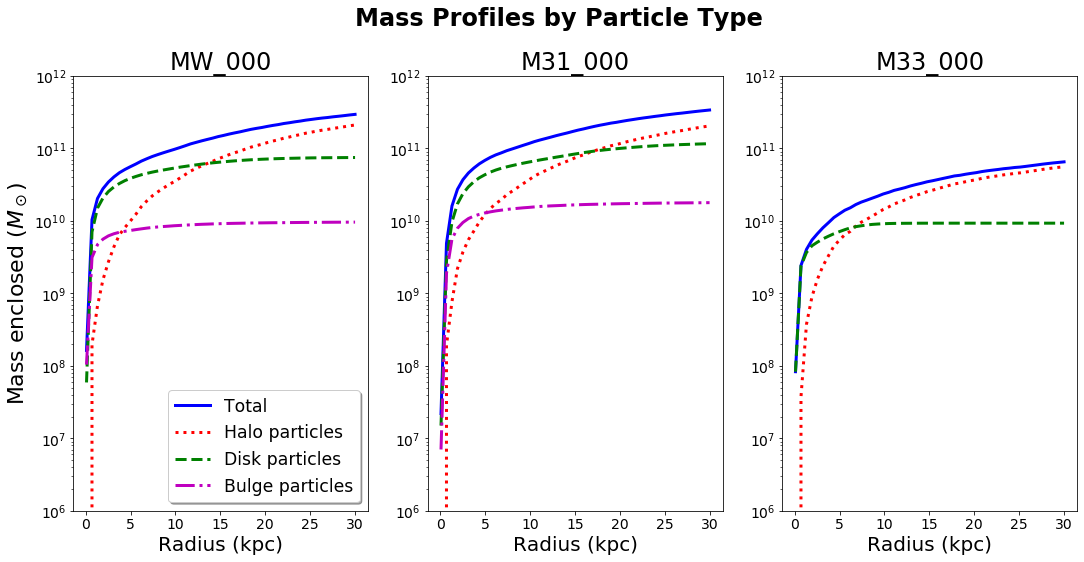

In [95]:
assert len(names) == 3 # MW, M31, M33 - matching the 3 subplots below
fig = plt.figure(figsize=(18,8))
subplots = (131, 132, 133)

for i in range(len(names)):
    # set up this subplot
    ax = plt.subplot(subplots[i])
    gname, mp = mass_profiles[i]
    
    # add the curves
    ax.semilogy(radii, mp.mass_enclosed_total(radii), 'b-', lw=3, label='Total')
    ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, label='Halo particles')
    ax.semilogy(radii, mp.mass_enclosed(radii, 2), 'g--', lw=3, label='Disk particles')
    ax.semilogy(radii, mp.mass_enclosed(radii, 3), 'm-.', lw=3, label='Bulge particles')

    #adjust tick label font size
    label_size = 14
    rcParams['xtick.labelsize'] = label_size 
    rcParams['ytick.labelsize'] = label_size

    # Add labels and subplot title
    ax.set_xlabel('Radius (kpc)', fontsize=20)
    if i == 0: # left subplot only
        ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
        ax.legend(loc='lower right',fontsize='xx-large', shadow=True)
    ax.set_title(gname, fontsize=24)

    #set axis limits
    ax.set_ylim(1e6, 1e12)

# Overall title
fig.suptitle(f'Mass Profiles by Particle Type', y=1.0, fontsize=24, weight='bold');

## Hernquist profiles

First a plot similar to the one above, but for theoretical profiles:

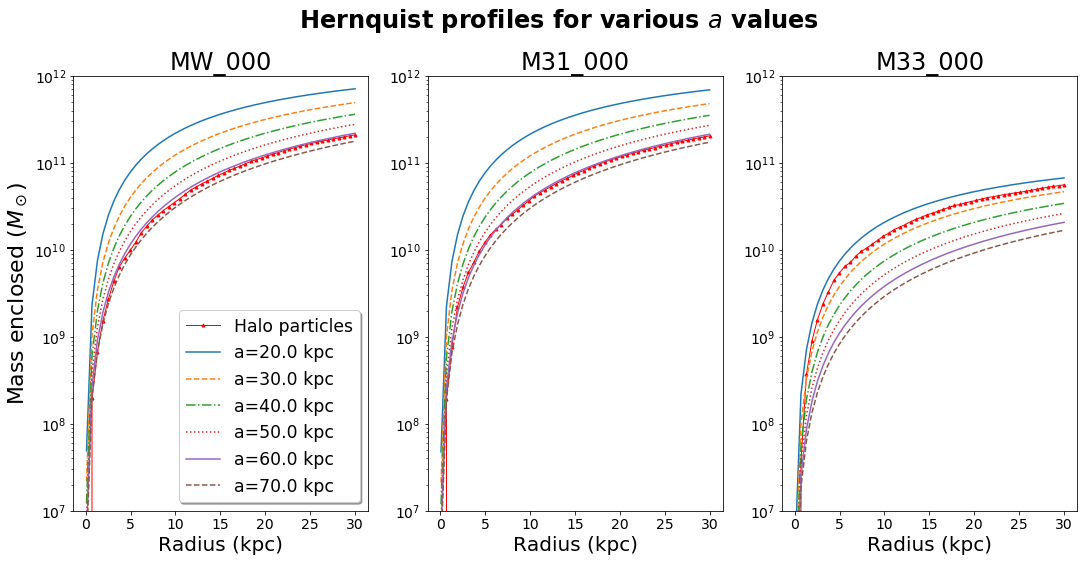

In [96]:
assert len(names) == 3
fig = plt.figure(figsize=(18,8))
subplots = (131, 132, 133)
linestyles = ['-', '--', '-.', ':']

for i in range(len(names)):
    # set up the subplot
    ax = plt.subplot(subplots[i])
    gname, mp = mass_profiles[i]
    
    # add the halo particles from our model data
    ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r-^', ms=4, lw=1, label='Halo particles')
    
    # add theoretical curves for a plausible range of scale length values
    for j, a in enumerate(np.arange(20, 80, 10) * u.kpc):
        ax.semilogy(radii, mp.hernquist_mass(radii, a), ls=linestyles[j%4], label=f'a={a}')
        
    #set axis limits
    ax.set_ylim(1e7, 1e12)

    #adjust tick label font size
    label_size = 14
    rcParams['xtick.labelsize'] = label_size 
    rcParams['ytick.labelsize'] = label_size

    # Add labels
    ax.set_xlabel('Radius (kpc)', fontsize=20)
    if i == 0: # left subplot only
        ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
        ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

    ax.set_title(gname, fontsize=24)
    
fig.suptitle('Hernquist profiles for various $a$ values', y=1.0, fontsize=24, weight='bold');

By eyeball, the best fit is $a \approx 60$ for MW and M31, mid-20's for M33.

For comparison, get `scipy.optimize` to do a non-linear least squares fit:

In [43]:
from scipy.optimize import curve_fit

In [125]:
# A function suitable for curve_fit. Units must be removed.
def hq(r, a):
    masses = (mp.hernquist_mass(r*u.kpc, a*u.kpc)).value
    return np.log(masses)

# The fitting has problems inside 1 kpc, so use a more restricted 
# range of radii than for the plots
radii_outer = np.linspace(1, 30) * u.kpc

# a dictionary to gather the results
fitted_a = {}

# loop over galaxies
for mass_prof in mass_profiles:
    gname, mp = mass_prof
    
    # y values to fit to
    halo = np.log(mp.mass_enclosed(radii_outer, 1).value)
    
    # run the fit and store the optimum a value
    popt, pcov = curve_fit(hq, radii_outer, halo, (60,))
    fitted_a[gname] = np.round(popt[0], 1)*u.kpc

for k, v in fitted_a.items():
    print(f'{k:8s}: a = {v}')

MW_000  : a = 63.0 kpc
M31_000 : a = 60.1 kpc
M33_000 : a = 25.7 kpc


That's about what we estimated by eye, encouragingly.

## Rotation curves

Plot the three galaxies, with all axes matching:

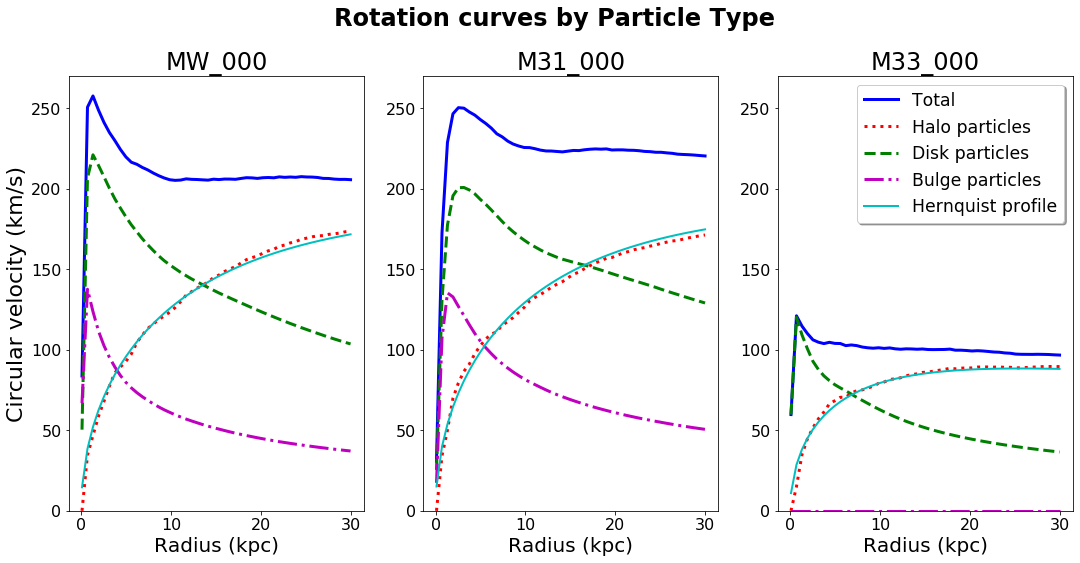

In [110]:
assert len(names) == 3
fig = plt.figure(figsize=(18,8))
subplots = (131, 132, 133)

for i in range(len(names)):
    ax = plt.subplot(subplots[i])
    gname, mp = mass_profiles[i]
    
    # the a value is from scipy.optimize, above
    a_opt = fitted_a[gname]
    
    # add the curves
    ax.plot(radii, mp.circular_velocity_total(radii), 'b-', lw=3, label='Total')
    ax.plot(radii, mp.circular_velocity(radii, 1), 'r:', lw=3, label='Halo particles')
    ax.plot(radii, mp.circular_velocity(radii, 2), 'g--', lw=3, label='Disk particles')
    
    # M33 has no bulge, but include it just to get a legend
    # The other subplots have no empty areas
    ax.plot(radii, mp.circular_velocity(radii, 3), 'm-.', lw=3, label='Bulge particles')
    
    # add the Hernquist profile, use our best-fit a 
    ax.plot(radii, mp.circular_velocity_hernquist(radii, a_opt), 'c-', lw=2, 
            label='Hernquist profile')

    #adjust tick label font size
    label_size = 16
    rcParams['xtick.labelsize'] = label_size 
    rcParams['ytick.labelsize'] = label_size

    # Add labels
    ax.set_xlabel('Radius (kpc)', fontsize=20)
    if i == 0: # left subplot only
        ax.set_ylabel(r'Circular velocity (km/s)', fontsize=22)
    if i == 2: # right subplot only
        ax.legend(fontsize='xx-large', shadow=True)
    ax.set_title(gname, fontsize=24)

    #set axis limits
    ax.set_ylim(0, 270)

fig.suptitle(f'Rotation curves by Particle Type', y=1.0, fontsize=24, weight='bold');

As expected, we can see that the baryonic particles give curves declining at large radius, where the dark matter halo dominates and keeps the total rotation curve fairly flat.

Fitting the Hernquist profile isn't perfect, but quite good.